In [5]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt


In [2]:


# Charger le csv
df = pd.read_csv("../vessel-total-clean-final.csv")

# Convertir la colonne date en datetime
df['base_date_time'] = pd.to_datetime(df['base_date_time'])

# Trier par mmsi + date (si plusieurs navires)
df = df.sort_values(['mmsi', 'base_date_time'])

# Calculer delta_seconds pour chaque MMSI

# Pour chaque MMSI, faire état actuel + état suivant
df['lat_next'] = df.groupby('mmsi')['lat'].shift(-1)
df['lon_next'] = df.groupby('mmsi')['lon'].shift(-1)
df['delta_seconds'] = df.groupby('mmsi')['base_date_time'].diff().shift(-1).dt.total_seconds()

# Enlever lignes sans target ou delta
df = df.dropna(subset=['lat_next', 'lon_next', 'delta_seconds'])

print(df[['lat', 'lon', 'lat_next', 'lon_next', 'delta_seconds']].head())

print(df.head)





             lat       lon  lat_next  lon_next  delta_seconds
110941  25.95847 -97.37876  25.95846 -97.37880          360.0
111259  25.95846 -97.37880  25.95847 -97.37880          180.0
111462  25.95847 -97.37880  25.95848 -97.37879          900.0
117554  25.95848 -97.37879  25.95846 -97.37882          180.0
113165  25.95846 -97.37882  25.95848 -97.37882          180.0
<bound method NDFrame.head of               id       mmsi      base_date_time       lat       lon  sog  cog  \
110941   9067786  205776000 2023-05-25 00:07:27  25.95847 -97.37876  0.0  0.0   
111259   9094320  205776000 2023-05-25 00:13:27  25.95846 -97.37880  0.0  0.0   
111462   9113012  205776000 2023-05-25 00:16:27  25.95847 -97.37880  0.0  0.0   
117554   9625845  205776000 2023-05-25 00:31:27  25.95848 -97.37879  0.0  0.0   
113165   9261545  205776000 2023-05-25 00:34:27  25.95846 -97.37882  0.0  0.0   
...          ...        ...                 ...       ...       ...  ...  ...   
374075  34248908  671830000 202

Creation des labels y

In [3]:
features = ['lat', 'lon', 'sog', 'cog', 'heading', 'length', 'draft', 'delta_seconds']
X = df[features]
y = df[['lat_next', 'lon_next']]

Estimation du meilleur modele

In [ ]:
# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer le modèle de base
rf = RandomForestRegressor(random_state=42)

# Créer le GridSearch avec cross-validation (ici cv=3 folds)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Lancer la recherche
grid_search.fit(X_train, y_train)

# Afficher le meilleur modèle et ses paramètres
print("✅ Meilleurs hyperparamètres :")
print(grid_search.best_params_)

print("✅ Score CV (MSE négatif) :", grid_search.best_score_)

# Extraire le meilleur modèle
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  21.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  21.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  43.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  22.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  22.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  43.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  43.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  23.4s
[CV] END max_depth=5, min_samples_leaf=1, m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.4min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  51.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.8min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.8min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  50.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  50.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=

In [ ]:
model = best_model
# Entraîner le modèle sur l'ensemble d'entraînement
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
y_pred = model.predict(X_test)

In [20]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Statistiques de performance :")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

Statistiques de performance :
RMSE : 0.0490
MAE  : 0.0016
R²   : 0.9996


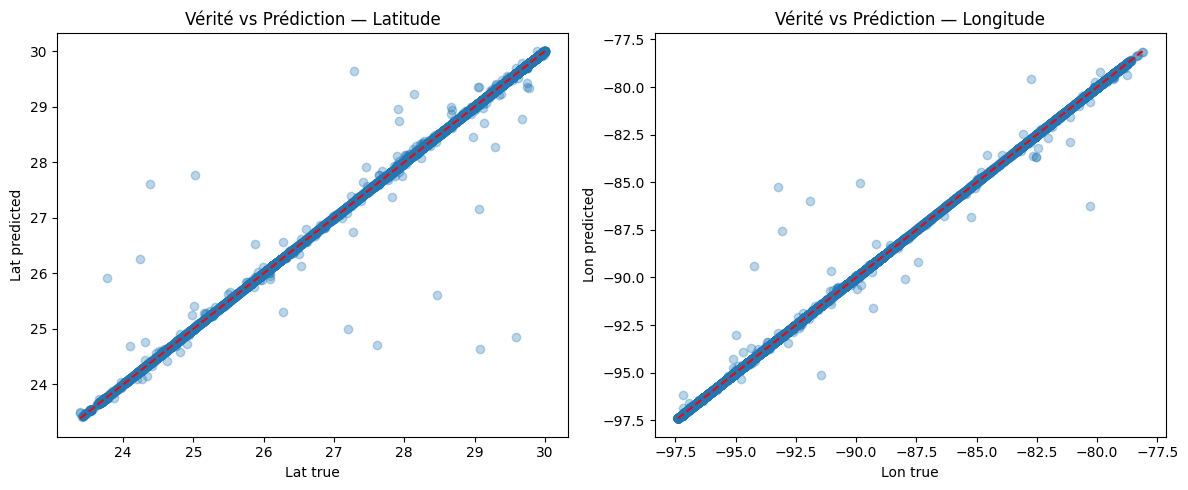

In [15]:
plt.figure(figsize=(12,5))

# Pour latitude
plt.subplot(1,2,1)
plt.scatter(y_test.iloc[:,0], y_pred[:,0], alpha=0.3)
plt.plot([y_test.iloc[:,0].min(), y_test.iloc[:,0].max()],
         [y_test.iloc[:,0].min(), y_test.iloc[:,0].max()],
         'r--')
plt.title("Vérité vs Prédiction — Latitude")
plt.xlabel("Lat true")
plt.ylabel("Lat predicted")

# Pour longitude
plt.subplot(1,2,2)
plt.scatter(y_test.iloc[:,1], y_pred[:,1], alpha=0.3)
plt.plot([y_test.iloc[:,1].min(), y_test.iloc[:,1].max()],
         [y_test.iloc[:,1].min(), y_test.iloc[:,1].max()],
         'r--')
plt.title("Vérité vs Prédiction — Longitude")
plt.xlabel("Lon true")
plt.ylabel("Lon predicted")

plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(model, "trajectoire.pkl")

['trajectoire.pkl']